In [306]:
import sys
sys.path.append("../scripts/")

In [307]:
from conn import connection
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Delivery Performance Analysis

In [309]:
query = """
select
	o.order_id,
    o.order_status,
    o.order_purchase_timestamp,
    o.order_delivered_customer_date as delivery_date,
    o.order_estimated_delivery_date as delivery_estimate_date,
    c.customer_state,
    round(freight.total_freight_value,2) as freight_value
from orders o
join customers c on o.customer_id = c.customer_id
left join(
	select order_id, SUM(freight_value) AS total_freight_value
    from order_items
    group by order_id
) as freight on o.order_id = freight.order_id;
"""

In [310]:
engine = connection()

Connection success


In [311]:
df = pd.read_sql(query, engine)

In [312]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   order_id                  99441 non-null  object 
 1   order_status              99441 non-null  object 
 2   order_purchase_timestamp  99441 non-null  object 
 3   delivery_date             96476 non-null  object 
 4   delivery_estimate_date    99441 non-null  object 
 5   customer_state            99441 non-null  object 
 6   freight_value             98666 non-null  float64
dtypes: float64(1), object(6)
memory usage: 5.3+ MB


In [313]:
df.duplicated().sum()

0

In [314]:
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'], errors='coerce')
df['delivery_date'] = pd.to_datetime(df['delivery_date'], errors='coerce')
df['delivery_estimate_date'] = pd.to_datetime(df['delivery_estimate_date'], errors='coerce')

In [315]:
df.isnull().sum()

order_id                       0
order_status                   0
order_purchase_timestamp       0
delivery_date               2965
delivery_estimate_date         0
customer_state                 0
freight_value                775
dtype: int64

In [316]:
# filling the delivery_date null values with status delivered

delivery_days = (df['delivery_estimate_date'] - df['delivery_date']).dt.days
avg_delivery_days = round(delivery_days.mean(),0)

In [317]:
mask = df['delivery_date'].isna() & df['order_status'] == 'delivered'

In [318]:
df.loc[mask, 'delivery_date'] = df.loc[mask, 'delivery_estimate_date'] - pd.to_timedelta(avg_delivery_days, unit='D')

## Average delivery time (actual vs estimated)

In [320]:
delivered_df = df[
    (df['order_status'] == 'delivered') &
    (df['delivery_date'].notna()) &
    (df['delivery_estimate_date'].notna())
].copy()

In [321]:
delivered_df['delivery_diff_days'] = (
    delivered_df['delivery_date'] - delivered_df['delivery_estimate_date']
).dt.days

In [322]:
average_diff = round(delivered_df['delivery_diff_days'].mean(),0)
print("Average delivery difference:", average_diff, "days")

Average delivery difference: -12.0 days


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


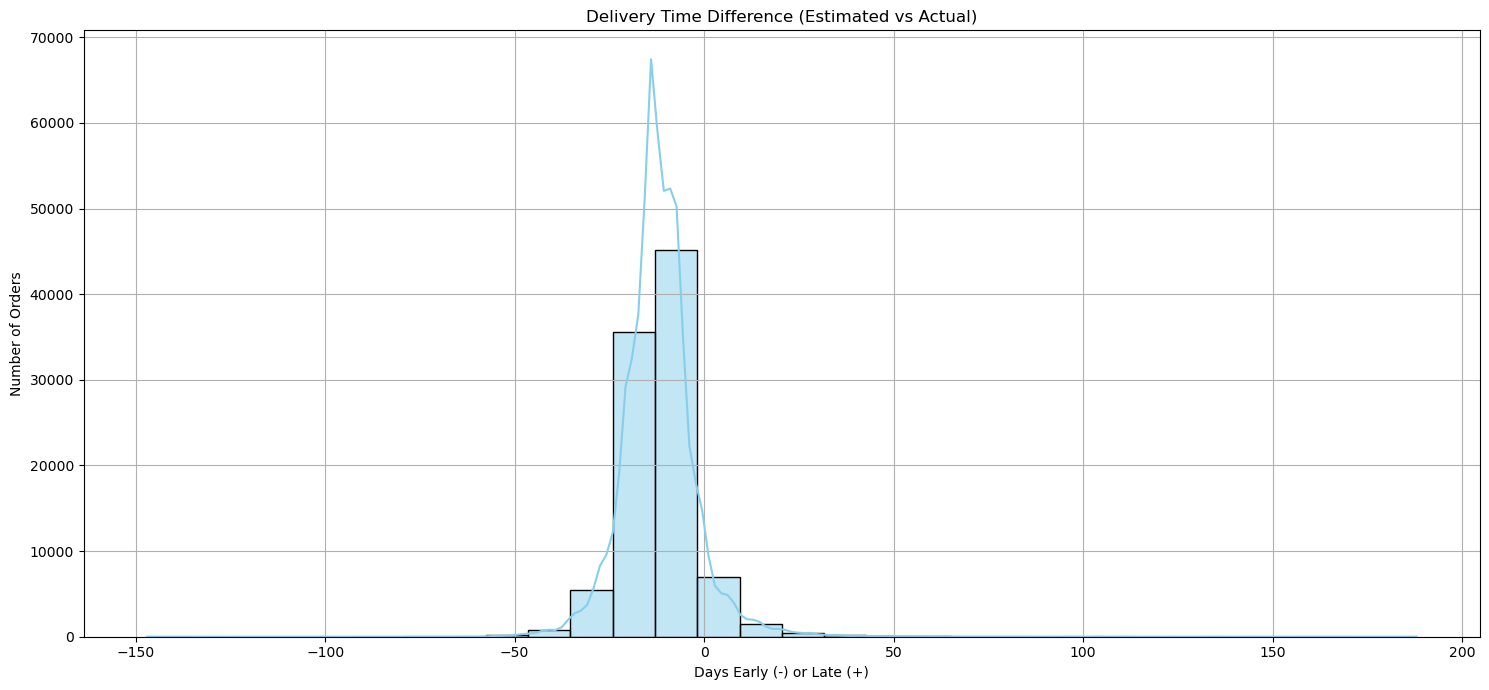

In [323]:
plt.figure(figsize=(15,7))
sns.histplot(delivered_df['delivery_diff_days'], bins=30, kde=True, color='skyblue',edgecolor='black' )

plt.title("Delivery Time Difference (Estimated vs Actual)")
plt.xlabel("Days Early (-) or Late (+)")
plt.ylabel("Number of Orders")
plt.grid(True)
plt.tight_layout()
plt.show()

## Delays by state

In [325]:
delays_by_state = delivered_df.groupby('customer_state')['delivery_diff_days'].mean().sort_values()

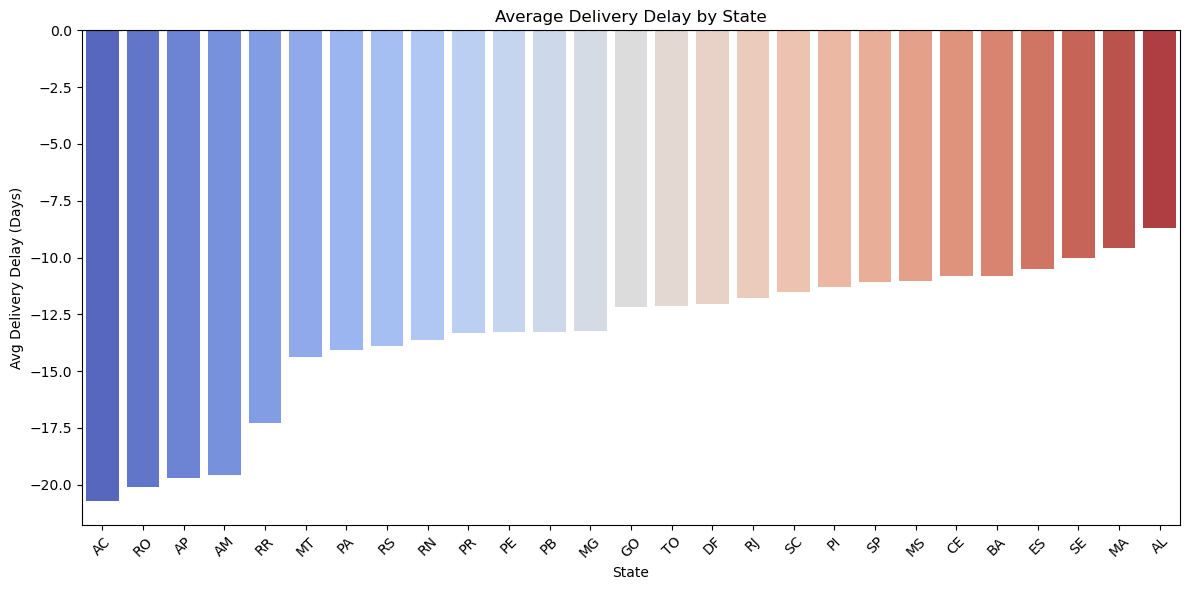

In [326]:
plt.figure(figsize=(12, 6))
sns.barplot(
    x=delays_by_state.index,
    y=delays_by_state.values,
    palette='coolwarm'
)
plt.axhline(0, color='black', linestyle='--')
plt.title('Average Delivery Delay by State')
plt.xlabel('State')
plt.ylabel('Avg Delivery Delay (Days)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Freight cost vs delivery time

In [353]:
df.head()

,order_id,order_status,order_purchase_timestamp,delivery_date,delivery_estimate_date,customer_state,freight_value
0,0197cb265e2c84b9f89dfd784095d2f6,delivered,2017-12-21 20:55:24,2017-12-28 16:37:08,2018-01-30,MS,58.91
1,0438fc3e115633e11a93c878a1591016,delivered,2018-08-11 20:58:44,2018-08-20 22:57:43,2018-08-28,BA,15.22
2,011b142c9e082a5c1d10e0a88cd9c8e8,delivered,2018-03-23 11:43:13,2018-04-14 19:18:26,2018-04-16,MA,53.83
3,05ae7d6bd78e2a61f4c0076a9d690aa8,delivered,2018-07-20 12:25:03,2018-07-25 14:08:33,2018-08-01,SP,16.83
4,062d3e3b803bd3e569cf8c165602f8f4,delivered,2018-06-25 17:26:38,2018-07-05 17:28:53,2018-07-26,SP,63.11


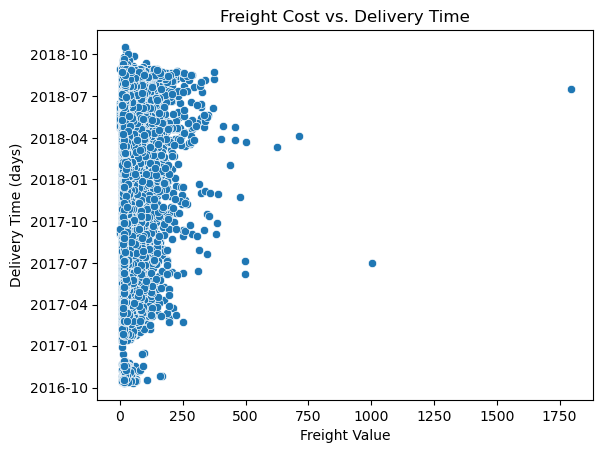

In [376]:
sns.scatterplot(data=delivered_df, x='freight_value', y='delivery_date')
plt.title('Freight Cost vs. Delivery Time')
plt.xlabel('Freight Value')
plt.ylabel('Delivery Time (days)')
plt.show()

In [378]:
delivered_df[['freight_value', 'delivery_date']].corr()

,freight_value,delivery_date
freight_value,1.000000,0.048463
delivery_date,0.048463,1.000000
